In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [8]:
# Load datasets

# For training
X_train = np.load('data/X_train.npy')
Y_train = np.load('data/Y_train.npy')

# For validation
X_val = np.load('data/X_val.npy')
Y_val = np.load('data/Y_val.npy')

In [9]:
X_train

array([[[ 0.00000000e+00,  0.00000000e+00, -1.43944310e+01],
        [ 0.00000000e+00,  0.00000000e+00,  2.75132312e+01],
        [ 0.00000000e+00,  0.00000000e+00,  2.18579727e+02],
        ...,
        [ 2.89304979e+00,  1.51195407e+00,  4.04783567e-01],
        [ 1.24365420e+00, -7.08885126e-01,  1.77207027e+00],
        [ 4.55580658e-02,  1.69058844e+00, -1.27324518e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  4.25974648e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00854060e+01],
        [ 0.00000000e+00,  0.00000000e+00,  2.93576085e+02],
        ...,
        [ 3.68471999e+00, -4.58704627e+00, -7.30733706e+00],
        [ 1.23746583e+00,  5.77858202e+00, -5.27865571e+00],
        [-2.69344563e+00,  3.69042317e+00, -1.54934711e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  6.72886934e+01],
        [ 0.00000000e+00,  0.00000000e+00,  2.87311545e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.40597388e+02],
        ...,
        [ 2.83666070e+00, -7.47965109e+00,

In [5]:
# Initialize model
model = keras.models.Sequential([
    keras.layers.SeparableConv1D(kernel_size=8, activation='tanh',padding='SAME',filters=32),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.SeparableConv1D(kernel_size=8, activation='tanh',padding='SAME',filters=64),
    keras.layers.SeparableConv1D(kernel_size=8, activation='tanh',padding='SAME',filters=64),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.SeparableConv1D(kernel_size=4, activation='relu',padding='SAME',filters=128),
    keras.layers.SeparableConv1D(kernel_size=4, activation='relu',padding='SAME',filters=128),
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(3)
])

# Compile model
model.compile(loss="mae", optimizer = keras.optimizers.Adam(),metrics=["mae"])

In [6]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_loss',restore_best_weights=True) # Stop training if validation loss is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=300) # Reduce learning rate is the validation loss is not improving

In [7]:
# Train
history = model.fit(X_train, Y_train, epochs=5000, validation_data=(X_val, Y_val), batch_size=16, callbacks=[early_stopping_cb, learning_rate_cb], verbose=False)

Text(0, 0.5, 'mae')

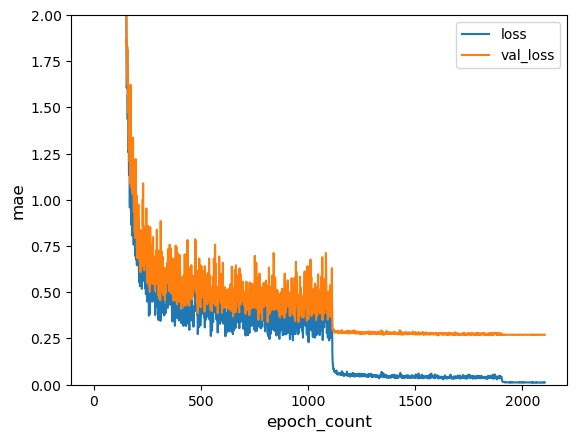

In [8]:
# Plot
h_cnn = history.history
history_df = pd.DataFrame(history.history)
ax= history_df.loc[:, ['loss', 'val_loss']].plot();
ax.set_ylim(0,2)
ax.set_xlabel(r'epoch_count',fontsize=12)
ax.set_ylabel(r'mae',fontsize=12)

# Test model

Let us test the model on a dataset which the model has not seen before. We will compare it to a baseline model that estimates the target field as the average of sensors' values.

In [9]:
X_test = np.load('data/X_test.npy')
Y_test = np.load('data/Y_test.npy')

# Apply model to predict the target field
Y_pred = model.predict(X_test)

# Use average field as a baseline model
Y_base = X_test.mean(axis=1)

8/8 [==============================] - 0s 2ms/step


First we will look at the worst case scenario by calculating the maximum absolute error.

In [10]:
# Network prediction
print('Network', np.abs(Y_test-Y_pred).max())

# Baseline prediction
print('Average', np.abs(Y_test-Y_base).max())

Network 1.8340258509352036
Average 127.6208408167237


We can see that network beats the baseline. Now, let us visualize the model performance in terms of the magnitude of the predicted magnetic field.

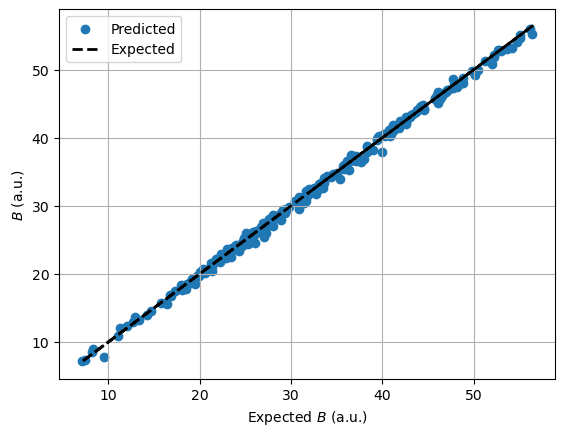

In [13]:
fig, ax = plt.subplots()
ax.scatter(np.sqrt((Y_test**2).sum(axis=1)), np.sqrt((Y_pred**2).sum(axis=1)), label = 'Predicted')
ax.plot(np.sqrt((Y_test**2).sum(axis=1)), np.sqrt((Y_test**2).sum(axis=1)), linewidth=2.0, ls='--', label = 'Expected', color = 'black')
ax.set_ylabel(r'$B$ (a.u.)')
ax.set_xlabel(r'Expected $B$ (a.u.)')
ax.legend(loc=0)
ax.grid()

The agreement is not terrible, but can be improved by reducing overfitting during the training. Note that there is no data around zero, even though the data was generated based on random voltages uniformly distributed between -10 and 10. We could solve it by adding data with a smaller range.

# Plot and save model

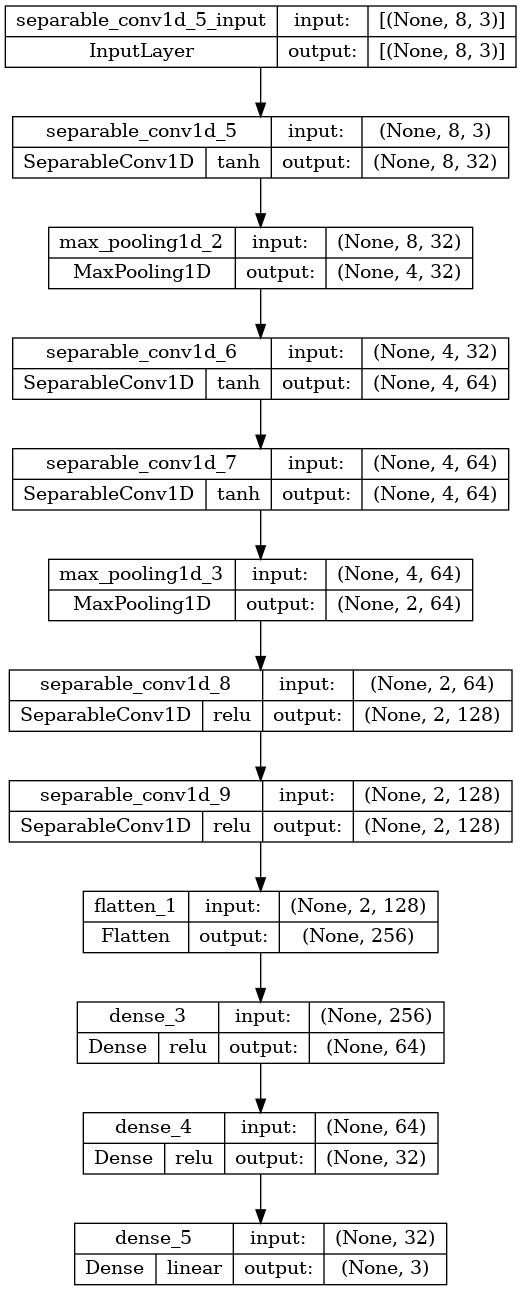

In [14]:
# Plot
from keras.utils import plot_model
plot_model(model, show_shapes=True,
           to_file='model.png',show_layer_activations=True)

In [15]:
model.save('data/model.h5')